In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

In [26]:
# Metrics
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    RMSE = [mean_squared_error(y_train, model.predict(X_train),squared=False), mean_squared_error(y_test, y_pred, squared=False)]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])


In [3]:
df = pd.read_csv('listings_prepar.csv', sep=',')
df=df.dropna()
df

,number_of_reviews,calculated_host_listings_count,availability_365,datetime_diff,room_type=0,room_type=1,room_type=2,room_type=3,price
0,65.0,1.0,53.0,766.0,0.0,0.0,1.0,0.0,70.0
1,33.0,2.0,48.0,1182.0,0.0,0.0,1.0,0.0,17.0
2,2.0,1.0,354.0,1559.0,1.0,0.0,0.0,0.0,80.0
3,64.0,1.0,301.0,825.0,1.0,0.0,0.0,0.0,115.0
4,136.0,1.0,337.0,822.0,0.0,0.0,1.0,0.0,25.0
...,...,...,...,...,...,...,...,...,...
7665,36.0,2.0,116.0,818.0,1.0,0.0,0.0,0.0,30.0
7666,43.0,1.0,344.0,818.0,0.0,0.0,1.0,0.0,50.0
7667,58.0,2.0,94.0,762.0,0.0,0.0,1.0,0.0,75.0
7668,67.0,1.0,331.0,779.0,1.0,0.0,0.0,0.0,60.0


In [14]:
X = df.iloc[:, :-1].values
y = df.iloc[:, 1].values
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=0)
X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)
y_train = train.price
y_test = test.price

In [15]:
X_train.shape, X_test.shape

((6136, 8), (1534, 8))

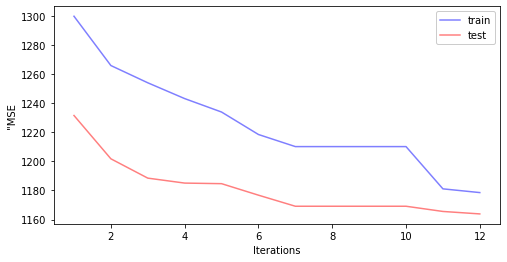

In [16]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train, y_train,eval_set=(X_test, y_test),logging_level='Silent')
        mse_train.append(mean_squared_error(y_train, catboost.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, catboost.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel('"MSE')
    ax.set_xlabel('Iterations')
    ax.legend(framealpha=1, frameon=True);
    
from catboost import CatBoostRegressor
catboost_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,13)))

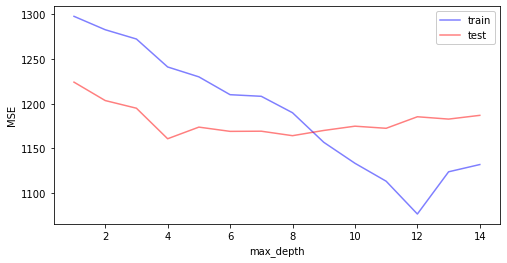

In [17]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=7,max_depth=i,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train,y_train,eval_set=(X_test, y_test),logging_level='Silent')
        mse_train.append(mean_squared_error(y_train, catboost.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, catboost.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

catboost_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [18]:

# Fitting CatBoost to the Training set
cb = CatBoostRegressor(iterations=7,max_depth=9,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train, y_train,eval_set=(X_test, y_test),logging_level='Silent')

# Predicting the Test set results
cb_y_pred = cb.predict(X_test)

# Metrics
metrics(X_train, X_test, y_train, y_test, cb_y_pred, cb).round(2)

,RMSE,R2
Train,34.01,0.16
Test,34.21,0.11


In [19]:
X_test['number_of_reviews']

3099     13.0
7610      1.0
2172     26.0
2242     17.0
5854    100.0
        ...  
7021      1.0
34        4.0
113       7.0
1554    144.0
917      96.0
Name: number_of_reviews, Length: 1534, dtype: float64

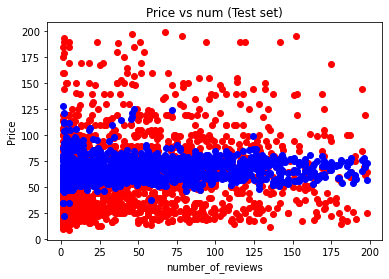

In [21]:
# Visualising the Test set results
plt.scatter(X_test['number_of_reviews'], y_test, color = 'red')
plt.plot(X_test['number_of_reviews'], cb.predict(X_test), 'bo')
plt.title('Price vs num (Test set)')
plt.xlabel('number_of_reviews')
plt.ylabel('Price')
plt.show()

In [25]:
metric_cb = metrics(X_train, X_test, y_train,y_test, cb_y_pred, cb).round(2)
metric_cb['Type'] = 'Catboost'

metric = pd.concat([metric_cb])
metric

,RMSE,R2,Type
Train,34.01,0.16,Catboost
Test,34.21,0.11,Catboost


In [ ]:
#модель кетбустинга справляется получше и дает показатели немного качественнее, но все равно далекие от реального применения модели
#тем 